In [9]:
require 'torch'

os.execute('wget -c http://www.cs.toronto.edu/~kriz/cifar-10-binary.tar.gz')
os.execute('tar -xvf cifar-10-binary.tar.gz')
local function convertCifar10BinToTorchTensor(inputFnames, outputFname)
   local nSamples = 0
   for i=1,#inputFnames do
      local inputFname = inputFnames[i]
      local m=torch.DiskFile(inputFname, 'r'):binary()
      m:seekEnd()
      local length = m:position() - 1
      local nSamplesF = length / 3073 -- 1 label byte, 3072 pixel bytes
      assert(nSamplesF == math.floor(nSamplesF), 'expecting numSamples to be an exact integer')
      nSamples = nSamples + nSamplesF
      m:close()
   end

   local label = torch.ByteTensor(nSamples)
   local data = torch.ByteTensor(nSamples, 3, 32, 32)

   local index = 1
   for i=1,#inputFnames do
      local inputFname = inputFnames[i]
      local m=torch.DiskFile(inputFname, 'r'):binary()
      m:seekEnd()
      local length = m:position() - 1
      local nSamplesF = length / 3073 -- 1 label byte, 3072 pixel bytes
      m:seek(1)
      for j=1,nSamplesF do
         label[index] = m:readByte()
         local store = m:readByte(3072)
         data[index]:copy(torch.ByteTensor(store))
         index = index + 1
      end
      m:close()
   end

   local out = {}
   out.data = data
   out.label = label
   print(out)
   torch.save(outputFname, out)
end

convertCifar10BinToTorchTensor({'cifar-10-batches-bin/data_batch_1.bin',
                                'cifar-10-batches-bin/data_batch_2.bin',
                                'cifar-10-batches-bin/data_batch_3.bin',
                                'cifar-10-batches-bin/data_batch_4.bin',
                                'cifar-10-batches-bin/data_batch_5.bin'},
   'cifar10-train.t7')

convertCifar10BinToTorchTensor({'cifar-10-batches-bin/test_batch.bin'},
   'cifar10-test.t7')

cifar-10-batches-bin/


cifar-10-batches-bin/data_batch_1.bin


cifar-10-batches-bin/batches.meta.txt
cifar-10-batches-bin/data_batch_3.bin


cifar-10-batches-bin/data_batch_4.bin


cifar-10-batches-bin/test_batch.bin


cifar-10-batches-bin/readme.html
cifar-10-batches-bin/data_batch_5.bin


cifar-10-batches-bin/data_batch_2.bin


{
  data : ByteTensor - size: 50000x3x32x32


  label : ByteTensor - size: 50000
}


{
  data : ByteTensor - size: 10000x3x32x32
  label : ByteTensor - size: 10000
}


In [1]:
require 'nn';
require 'paths'
trainset = torch.load('cifar10-train.t7')
testset = torch.load('cifar10-test.t7')
classes = {'airplane', 'automobile', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck'}

In [2]:
trainset.label = trainset.label+1
testset.label = testset.label+1

In [3]:
-- ignore setmetatable for now, it is a feature beyond the scope of this tutorial. It sets the index operator.
setmetatable(trainset, 
    {__index = function(t, i) 
                    return {t.data[i], t.label[i]} 
                end}
);
trainset.data = trainset.data:double() -- convert the data from a ByteTensor to a DoubleTensor.

function trainset:size() 
    return self.data:size(1) 
end

-- ignore setmetatable for now, it is a feature beyond the scope of this tutorial. It sets the index operator.
setmetatable(testset, 
    {__index = function(t, i) 
                    return {t.data[i], t.label[i]} 
                end}
);
testset.data = testset.data:double() -- convert the data from a ByteTensor to a DoubleTensor.

function testset:size() 
    return self.data:size(1) 
end

In [4]:
r = trainset.data[{ {}, {1}, {}, {}  }]*0.21
g = trainset.data[{ {}, {2}, {}, {}  }]*0.72
b = trainset.data[{ {}, {3}, {}, {}  }]*0.07
trainset.data = r+g+b
r = testset.data[{ {}, {1}, {}, {}  }]*0.21
g = testset.data[{ {}, {2}, {}, {}  }]*0.72
b = testset.data[{ {}, {3}, {}, {}  }]*0.07
testset.data = r+g+b

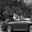

automobile	
2	


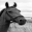

horse	
8	


In [5]:
itorch.image(trainset.data[100]) -- display the 100-th image in dataset
print(classes[trainset.label[100]])
print(trainset.label[100])
itorch.image(testset.data[100]) -- display the 100-th image in dataset
print(classes[testset.label[100]])
print(testset.label[100])

In [6]:
mean = {} -- store the mean, to normalize the test set in the future
stdv  = {} -- store the standard-deviation for the future
for i=1,1 do -- over each image channel
    mean[i] = trainset.data[{ {}, {i}, {}, {}  }]:mean() -- mean estimation
    print('Channel ' .. i .. ', Mean: ' .. mean[i])
    trainset.data[{ {}, {i}, {}, {}  }]:add(-mean[i]) -- mean subtraction
    
    stdv[i] = trainset.data[{ {}, {i}, {}, {}  }]:std() -- std estimation
    print('Channel ' .. i .. ', Standard Deviation: ' .. stdv[i])
    trainset.data[{ {}, {i}, {}, {}  }]:div(stdv[i]) -- std scaling
end
mean = {} -- store the mean, to normalize the test set in the future
stdv  = {} -- store the standard-deviation for the future

Channel 1, Mean: 122.80931339391	


Channel 1, Standard Deviation: 61.229392750446	


In [7]:
net = nn.Sequential()
net:add(nn.SpatialConvolution(1, 6, 5, 5)) -- 3 input image channels, 6 output channels, 5x5 convolution kernel
net:add(nn.ReLU())                       -- non-linearity 
net:add(nn.SpatialMaxPooling(2,2,2,2))     -- A max-pooling operation that looks at 2x2 windows and finds the max.
net:add(nn.SpatialConvolution(6, 16, 5, 5))
net:add(nn.ReLU())                       -- non-linearity 
net:add(nn.SpatialMaxPooling(2,2,2,2))
net:add(nn.View(16*5*5))                    -- reshapes from a 3D tensor of 16x5x5 into 1D tensor of 16*5*5
net:add(nn.Linear(16*5*5, 120))             -- fully connected layer (matrix multiplication between input and weights)
net:add(nn.ReLU())                       -- non-linearity 
net:add(nn.Linear(120, 84))
net:add(nn.ReLU())                       -- non-linearity 
net:add(nn.Linear(84, 10))                   -- 10 is the number of outputs of the network (in this case, 10 digits)
net:add(nn.LogSoftMax(1)) 

In [8]:
criterion = nn.ClassNLLCriterion()

In [9]:
require 'cunn';

In [10]:
net = net:cuda()

In [11]:
criterion = criterion:cuda()

In [12]:
targets=trainset.label:long()
one_hot_train = torch.eye(10):index(1, targets)
--targets=testset.label:long()
--one_hot_test = torch.eye(10):index(1, targets)

In [13]:
trainset.data = trainset.data:cuda()
--trainset.label = one_hot_train:cuda()
trainset.label = trainset.label:cuda()
testset.data = testset.data:cuda()
testset.label = testset.label:cuda()

In [14]:
trainer = nn.StochasticGradient(net, criterion)
trainer.learningRate = 0.001
trainer.maxIteration = 5 -- just do 5 epochs of training.

In [ ]:
tstart=os.time()
trainer:train(trainset)
tend=os.time()
print(os.difftime (tend , tstart))

# StochasticGradient: training	


In [20]:
correct = 0
for i=1,10000 do
    local groundtruth = testset.label[i]
    local prediction = net:forward(testset.data[i])
    local confidences, indices = torch.sort(prediction, true)  -- true means sort in descending order
    if groundtruth == indices[1] then
        correct = correct + 1
    end
end
print(correct, 100*correct/10000 .. ' % ')

3447	34.47 % 	


In [26]:
class_performance = {0, 0, 0, 0, 0, 0, 0, 0, 0, 0}
for i=1,10000 do
    local groundtruth = testset.label[i]
    local prediction = net:forward(testset.data[i])
    local confidences, indices = torch.sort(prediction, true)  -- true means sort in descending order
    if groundtruth == indices[1] then
        class_performance[groundtruth] = class_performance[groundtruth] + 1
    end
end
for i=1,#classes do
    print(classes[i], 100*class_performance[i]/1000 .. ' %')
end

airplane	53.4 %	
automobile	40.9 %	
bird	7 %	
cat	63.9 %	
deer	1.1 %	
dog	32.6 %	
frog	13 %	
horse	35.6 %	
ship	58 %	
truck	39.3 %	


In [18]:
parameters, gradParameters = net:getParameters()

In [26]:
dl = require 'dataload'
optim = require 'optim';
one_hot = torch.eye(10):index(1, targets)
dataloader = dl.TensorLoader(trainset.data, trainset.label)
i=0
batch_size=1000
epochs=100
tstart=os.time()

-- Define SGD parameters.
sgd_params = {
    learningRate = 0.01,
    weightDecay = 0,
    momentum = 0
}
for j=1,epochs do
    print("------ epoch - " ..j.. " ----- ")
    tot_loss=0
    for k, inputs, targets in dataloader:subiter(batch_size,50000) do
        -- Define a closure that computes the loss and dloss/dx.
        feval = function()
            -- reset gradients
            gradParameters:zero()
            output=net:forward(inputs)
            loss=criterion:forward(output, targets)
            gradients = criterion:backward(output, targets)
            net:backward(inputs, gradients)
            return loss, gradParameters
        end
        _,local_loss = optim.sgd(feval, parameters, sgd_params)
        tot_loss = tot_loss + local_loss[1]
    end
    print("------- loss - " ..(tot_loss/50).. " ------ ")
end

tend=os.time()
print("------ Time taken :",os.difftime (tend , tstart))

------ epoch - 1 ----- 	


------- loss - 1.5445520114899 ------ 	
------ epoch - 2 ----- 	


------- loss - 1.5161946678162 ------ 	
------ epoch - 3 ----- 	


------- loss - 1.5084426474571 ------ 	
------ epoch - 4 ----- 	


------- loss - 1.5021010661125 ------ 	
------ epoch - 5 ----- 	


------- loss - 1.4963849210739 ------ 	
------ epoch - 6 ----- 	


------- loss - 1.4910190582275 ------ 	
------ epoch - 7 ----- 	


------- loss - 1.4859037804604 ------ 	
------ epoch - 8 ----- 	


------- loss - 1.480972328186 ------ 	
------ epoch - 9 ----- 	


------- loss - 1.4761478900909 ------ 	
------ epoch - 10 ----- 	


------- loss - 1.4714289736748 ------ 	
------ epoch - 11 ----- 	


------- loss - 1.4668012571335 ------ 	
------ epoch - 12 ----- 	


------- loss - 1.4622626471519 ------ 	
------ epoch - 13 ----- 	


------- loss - 1.4577530169487 ------ 	
------ epoch - 14 ----- 	


------- loss - 1.4533131432533 ------ 	
------ epoch - 15 ----- 	


------- loss - 1.4489145112038 ------ 	
------ epoch - 16 ----- 	


------- loss - 1.4446056079865 ------ 	
------ epoch - 17 ----- 	


------- loss - 1.4403595519066 ------ 	
------ epoch - 18 ----- 	


------- loss - 1.4361528372765 ------ 	
------ epoch - 19 ----- 	


------- loss - 1.431984834671 ------ 	
------ epoch - 20 ----- 	


------- loss - 1.4278655958176 ------ 	
------ epoch - 21 ----- 	


------- loss - 1.4237718605995 ------ 	
------ epoch - 22 ----- 	


------- loss - 1.4197201061249 ------ 	
------ epoch - 23 ----- 	


------- loss - 1.4156726527214 ------ 	
------ epoch - 24 ----- 	


------- loss - 1.4116623234749 ------ 	
------ epoch - 25 ----- 	


------- loss - 1.4076785302162 ------ 	
------ epoch - 26 ----- 	


------- loss - 1.403733754158 ------ 	
------ epoch - 27 ----- 	


------- loss - 1.3998172831535 ------ 	
------ epoch - 28 ----- 	


------- loss - 1.3959399390221 ------ 	
------ epoch - 29 ----- 	


------- loss - 1.3920574975014 ------ 	
------ epoch - 30 ----- 	


------- loss - 1.3882205271721 ------ 	
------ epoch - 31 ----- 	


------- loss - 1.3844121217728 ------ 	
------ epoch - 32 ----- 	


------- loss - 1.3806583046913 ------ 	
------ epoch - 33 ----- 	


------- loss - 1.3769038319588 ------ 	
------ epoch - 34 ----- 	


------- loss - 1.3732007670403 ------ 	
------ epoch - 35 ----- 	


------- loss - 1.3695106387138 ------ 	
------ epoch - 36 ----- 	


------- loss - 1.3658824896812 ------ 	
------ epoch - 37 ----- 	


------- loss - 1.3622556138039 ------ 	
------ epoch - 38 ----- 	


------- loss - 1.3586653232574 ------ 	
------ epoch - 39 ----- 	


------- loss - 1.3551062488556 ------ 	
------ epoch - 40 ----- 	


------- loss - 1.3515806102753 ------ 	
------ epoch - 41 ----- 	


------- loss - 1.3480650401115 ------ 	
------ epoch - 42 ----- 	


------- loss - 1.3445839047432 ------ 	
------ epoch - 43 ----- 	


------- loss - 1.341130657196 ------ 	
------ epoch - 44 ----- 	


------- loss - 1.3377148342133 ------ 	
------ epoch - 45 ----- 	


------- loss - 1.3343263721466 ------ 	
------ epoch - 46 ----- 	


------- loss - 1.3309943962097 ------ 	
------ epoch - 47 ----- 	


------- loss - 1.3276665306091 ------ 	
------ epoch - 48 ----- 	


------- loss - 1.3243865990639 ------ 	
------ epoch - 49 ----- 	


------- loss - 1.3211324882507 ------ 	
------ epoch - 50 ----- 	


------- loss - 1.3179351878166 ------ 	
------ epoch - 51 ----- 	


------- loss - 1.314750828743 ------ 	
------ epoch - 52 ----- 	


------- loss - 1.3116173100471 ------ 	
------ epoch - 53 ----- 	


------- loss - 1.3085201072693 ------ 	
------ epoch - 54 ----- 	

------- loss - 1.3054322385788 ------ 	
------ epoch - 55 ----- 	

------- loss - 1.302368555069 ------ 	
------ epoch - 56 ----- 	


------- loss - 1.299304523468 ------ 	
------ epoch - 57 ----- 	


------- loss - 1.2963310742378 ------ 	
------ epoch - 58 ----- 	


------- loss - 1.2933792996407 ------ 	
------ epoch - 59 ----- 	


------- loss - 1.2905257916451 ------ 	
------ epoch - 60 ----- 	


------- loss - 1.2876408600807 ------ 	
------ epoch - 61 ----- 	


------- loss - 1.2848504781723 ------ 	
------ epoch - 62 ----- 	


------- loss - 1.2821293377876 ------ 	
------ epoch - 63 ----- 	


------- loss - 1.2794712519646 ------ 	
------ epoch - 64 ----- 	


------- loss - 1.2767864203453 ------ 	
------ epoch - 65 ----- 	


------- loss - 1.2742010521889 ------ 	
------ epoch - 66 ----- 	


------- loss - 1.271840531826 ------ 	
------ epoch - 67 ----- 	


------- loss - 1.2692185258865 ------ 	
------ epoch - 68 ----- 	


------- loss - 1.2667292761803 ------ 	
------ epoch - 69 ----- 	


------- loss - 1.2638710403442 ------ 	
------ epoch - 70 ----- 	


------- loss - 1.2614130735397 ------ 	
------ epoch - 71 ----- 	


------- loss - 1.2592467975616 ------ 	
------ epoch - 72 ----- 	


------- loss - 1.2566194438934 ------ 	
------ epoch - 73 ----- 	


------- loss - 1.2540092611313 ------ 	
------ epoch - 74 ----- 	


------- loss - 1.2517423796654 ------ 	
------ epoch - 75 ----- 	


------- loss - 1.2491884970665 ------ 	
------ epoch - 76 ----- 	


------- loss - 1.2468348383904 ------ 	
------ epoch - 77 ----- 	


------- loss - 1.2447370505333 ------ 	
------ epoch - 78 ----- 	


------- loss - 1.2422370362282 ------ 	
------ epoch - 79 ----- 	


------- loss - 1.2394675970078 ------ 	
------ epoch - 80 ----- 	


------- loss - 1.2372800803185 ------ 	
------ epoch - 81 ----- 	


------- loss - 1.2347007918358 ------ 	
------ epoch - 82 ----- 	


------- loss - 1.2319804286957 ------ 	
------ epoch - 83 ----- 	


------- loss - 1.2298572015762 ------ 	
------ epoch - 84 ----- 	


------- loss - 1.2268166851997 ------ 	
------ epoch - 85 ----- 	


------- loss - 1.2249116563797 ------ 	
------ epoch - 86 ----- 	


------- loss - 1.2218527007103 ------ 	
------ epoch - 87 ----- 	


------- loss - 1.2209546995163 ------ 	
------ epoch - 88 ----- 	


------- loss - 1.2166326451302 ------ 	
------ epoch - 89 ----- 	


------- loss - 1.2157779216766 ------ 	
------ epoch - 90 ----- 	


------- loss - 1.2127021360397 ------ 	
------ epoch - 91 ----- 	


------- loss - 1.2111831569672 ------ 	
------ epoch - 92 ----- 	


------- loss - 1.2050402545929 ------ 	
------ epoch - 93 ----- 	


------- loss - 1.2074022126198 ------ 	
------ epoch - 94 ----- 	


------- loss - 1.2020180511475 ------ 	
------ epoch - 95 ----- 	


------- loss - 1.2025539183617 ------ 	
------ epoch - 96 ----- 	


------- loss - 1.1945766234398 ------ 	
------ epoch - 97 ----- 	


------- loss - 1.194972243309 ------ 	
------ epoch - 98 ----- 	


------- loss - 1.1972498631477 ------ 	
------ epoch - 99 ----- 	


------- loss - 1.1870352268219 ------ 	
------ epoch - 100 ----- 	


------- loss - 1.1916127991676 ------ 	
------ Time taken :	537	


In [27]:
correct = 0
for i=1,10000 do
    local groundtruth = testset.label[i]
    local prediction = net:forward(testset.data[i])
    local confidences, indices = torch.sort(prediction, true)  -- true means sort in descending order
    if groundtruth == indices[1] then
        correct = correct + 1
    end
end
print(correct, 100*correct/10000 .. ' % ')

2941	29.41 % 	


In [28]:
class_performance = {0, 0, 0, 0, 0, 0, 0, 0, 0, 0}
for i=1,10000 do
    local groundtruth = testset.label[i]
    local prediction = net:forward(testset.data[i])
    local confidences, indices = torch.sort(prediction, true)  -- true means sort in descending order
    if groundtruth == indices[1] then
        class_performance[groundtruth] = class_performance[groundtruth] + 1
    end
end
for i=1,#classes do
    print(classes[i], 100*class_performance[i]/1000 .. ' %')
end

airplane	54.6 %	
automobile	85.8 %	
bird	0 %	
cat	8.9 %	
deer	0 %	
dog	50.7 %	
frog	0 %	
horse	32.7 %	
ship	27.3 %	
truck	34.1 %	
